In [1]:
import json

def load_corpus(file_path: str) -> dict[str, dict]:
    """
    Load corpus data from JSONL file.
    Returns dictionary mapping document IDs to document data.
    """
    corpus = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            doc = json.loads(line)
            id = doc.pop('_id')
            corpus[id] = doc
    return corpus

def load_queries(file_path: str) -> dict[str, dict]:
    """
    Load query data from JSONL file.
    Returns dictionary mapping query IDs to query data.
    """
    queries = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            query = json.loads(line)
            id = query.pop('_id')
            queries[id] = query
    return queries
    

def load_qrels(file_path: str) -> dict[str, dict[str, int]]:
    """
    Load relevance judgments from TSV file.
    Returns dictionary mapping query IDs to candidate relevance scores.
    """
    qrels = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        next(f)  # Skip header line
        for line in f:
            query_id, doc_id, score = line.strip().split('\t')
            if query_id not in qrels:
                qrels[query_id] = {}
            qrels[query_id][doc_id] = int(score)
    return qrels

def load_test(file_path: str) -> dict[str, dict[str, int]]:
    """
    Load test relevance judgments from TSV file.
    """
    test_set = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        next(f)  # Skip header line
        for line in f:
            query_id, doc_id, _ = line.strip().split('\t')
            if query_id not in test_set:
                test_set[query_id] = {}
            test_set[query_id][doc_id] = "#"
    return test_set

In [2]:
# Load the dataset
print("Loading dataset...")
corpus = load_corpus('data/corpus.jsonl')
queries = load_queries('data/queries.jsonl')
qrels_valid = load_qrels('data/valid.tsv')


print(f"Loaded {len(corpus)} documents in corpus")
print(f"Loaded {len(queries)} queries")
print(f"Loaded relevance for {len(qrels_valid)} queries (dataset)")

Loading dataset...
Loaded 25657 documents in corpus
Loaded 1000 queries
Loaded relevance for 700 queries (dataset)


In [3]:
def preprocessing(corpus, queries):
    preprocessed_corpus = {}
    preprocessed_queries = {}
    for doc_id, doc in corpus.items():
        preprocessed_corpus[doc_id] = f"{doc.get('title', '')}\n{doc.get('text', '')}"
    for query_id, query in queries.items():
        preprocessed_queries[query_id] = f"{query.get('text', '')}"
    return preprocessed_corpus, preprocessed_queries

text_corpus, text_queries = preprocessing(corpus, queries)

In [4]:
for id in qrels_valid.keys():
    num_positive_match = sum(qrels_valid[id].values())
    num_negative_match = len(qrels_valid[id]) - num_positive_match
    print(f"Query ID: {id}, positive Docs: {num_positive_match}, negative Docs: {num_negative_match}")

Query ID: 40c6b953b5c04b3df4164cd487c4bc00cf0e487d, positive Docs: 4, negative Docs: 25
Query ID: 2dbe49d7c9a65656cd46d22ea07dc317b26482b6, positive Docs: 5, negative Docs: 25
Query ID: 54356ff0960100e27cf17ff682825bba2662e90c, positive Docs: 5, negative Docs: 25
Query ID: f1256b20d202c73022d7a7f0151ba0010a074a06, positive Docs: 5, negative Docs: 25
Query ID: 8cb5835c4b4e042238304bfe7b0d96456714638a, positive Docs: 5, negative Docs: 25
Query ID: 0f5d0494c0ddaa32b5072dec141a9a79104d967b, positive Docs: 5, negative Docs: 25
Query ID: c445e43dfac5aa734f2929944fcb5c68a319b0b6, positive Docs: 5, negative Docs: 25
Query ID: c7c9cc68fed535c3c9d813a852e4a9e8a8eedb01, positive Docs: 5, negative Docs: 25
Query ID: 23ce229565447f22d5ef2b6d7cbd6d8003254ac2, positive Docs: 5, negative Docs: 25
Query ID: 36ea0a9710b9310ce9c6ce199af63b6a00eea480, positive Docs: 5, negative Docs: 25
Query ID: e642d6014a5762128a28f85dae2228826e682974, positive Docs: 5, negative Docs: 25
Query ID: 2a65434d43ffa6554eaf14

## Encodage des documents

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

def filter_corpus(corpus: dict[str, dict], filter: str = 'title') -> dict[str, dict]:
    """
    Keep only titles
    """
    filtered_corpus = {doc_id: doc[filter] for doc_id, doc in corpus.items()}
    return filtered_corpus

count_vectorizer = CountVectorizer()
X_corpus = count_vectorizer.fit_transform(text_corpus.values())
X_corpus.shape

(25657, 78277)

In [6]:
import pandas as pd
from scipy.sparse import find

def print_feats(v, features, top_n = 30):
    _, ids, values = find(v)
    feats = [(ids[i], values[i], features[ids[i]]) for i in range(len(list(ids)))]
    top_feats = sorted(feats, key=lambda x: x[1], reverse=True)[0:top_n]
    return pd.DataFrame({"word" : [t[2] for t in top_feats], "value": [t[1] for t in top_feats]}) 

print_feats(X_corpus[0], count_vectorizer.get_feature_names_out())

,word,value
0,the,13
1,in,10
2,is,10
3,and,9
4,recurrent,9
5,of,8
6,network,7
7,elites,6
8,to,6
9,by,5


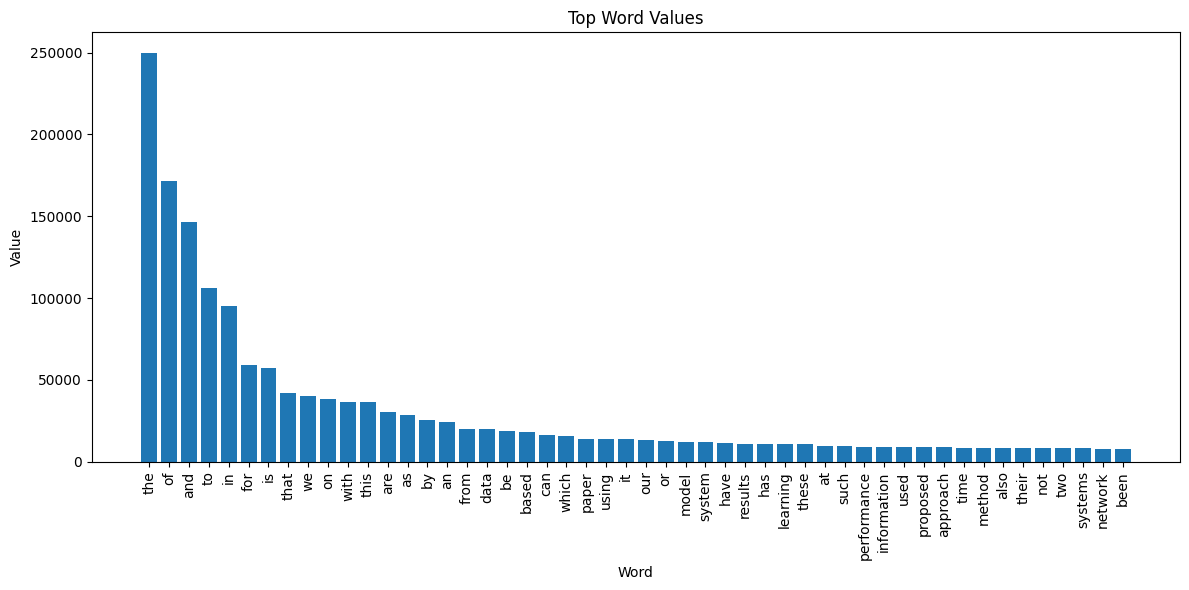

In [7]:
import matplotlib.pyplot as plt

df = print_feats(X_corpus.sum(axis=0), count_vectorizer.get_feature_names_out(), top_n=50)
plt.figure(figsize=(12, 6))
plt.bar(df["word"], df["value"])
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Value")
plt.title("Top Word Values")
plt.tight_layout()
plt.show()

In [8]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

ids = np.random.randint(0, X_corpus.shape[0]-1, size=2,)
similary = cosine_similarity(X_corpus[ids[0]], X_corpus[ids[1]])

print(f"Document 1:\n {list(text_corpus.values())[ids[0].item()]}")
print(f"Document 2:\n {list(text_corpus.values())[ids[1].item()]}")
print(f"similary: {similary.item()*100:.3f}%")

Document 1:
 Implicit and Explicit Stereotyping of Adolescents
Although adolescents are commonly assumed to be rebellious, risky and moody, two experiments demonstrate for the first time that these beliefs operate both explicitly and implicitly as stereotypes. In Experiment 1, participants (a) explicitly endorsed adolescent stereotypes and (b) implicitly associated adolescent stereotyped words more rapidly with the adolescent than the adult social category. Individual differences in the explicit endorsement of adolescent stereotypes predicted explicit perceptions of the rebelliousness of a 17-year-old but not a 71-year-old, although individual differences in implicit stereotyping did not. Identification with adults was associated with greater implicit stereotyping but not explicit stereotyping. In Experiment 2, subliminal exposure to adolescent stereotyped words increased subsequent perceptions of the rebelliousness of a 17-year-old but not a 71-year-old. Although individual difference

In [9]:
X_queries = count_vectorizer.transform(text_queries.values())
X_queries.shape

(1000, 78277)

In [10]:
def query_document_similarity(query_vector, document_vectors, top_k: int = 10):
    similarities = cosine_similarity(query_vector, document_vectors)
    similarities = similarities.squeeze()

    # On récupère les top_k meilleurs scores et indices associés
    top_indices = np.argsort(-similarities)[:top_k]
    top_scores = np.take_along_axis(similarities, top_indices, axis=0)
    return top_indices.squeeze(), top_scores.squeeze()

In [11]:
import random

def simple_browser(query, corpus, vectorizer, top_k=10):
    corpus_ids = list(corpus.keys())

    X_corpus = vectorizer.fit_transform(corpus.values())
    X_query = vectorizer.transform(query.values())
    top_indices, top_scores = query_document_similarity(X_query, X_corpus, top_k=top_k)
    
    results = {corpus_ids[idx]: float(top_scores[i]) for i, idx in enumerate(top_indices)}
    return results

random_id = random.choice(list(text_queries.keys()))
text_query = {random_id: text_queries[random_id]}

results = simple_browser(text_query, text_corpus, count_vectorizer, top_k=10)
results

{'10dae7fca6b65b61d155a622f0c6ca2bc3922251': 0.40201512610368484,
 '563e821bb5ea825efb56b77484f5287f08cf3753': 0.35355339059327373,
 '0c9c4daa230bcc62cf3d78236ccf54ff686a36e0': 0.3413466335496002,
 '0160ec003ae238a98676b6412b49d4b760f63544': 0.34020690871988585,
 '05c025af60aeab10a3069256674325802c844212': 0.33626508136735883,
 '084459cc2b4499ae8ae4a0edea46687900a0c4d4': 0.3333333333333333,
 '69bec56035163a2e6da9bf91921c05b9d3ae8d67': 0.32319656328389157,
 'e9bb3ca7558ea0ce9ca7d5c965e4179668d69d0a': 0.32213907696158245,
 'c4f05354ce6776dd1a3a076c9cc60614ee38476e': 0.3200529056794555,
 '418432bc00011c24ea9ceaa0f25f6d75d50bee9f': 0.3053857783007297}

In [12]:
import numpy as np

def save_embeddings(encoder, texts: dict[str, str], file_path: str, device='cpu'):
    ids = np.array(list(texts.keys()))
    vectors = encoder.encode(list(texts.values()), device=device, convert_to_numpy=True, show_progress_bar=True)
    np.savez(file_path, ids=ids, vectors=vectors)

def load_embeddings(file_path: str):
    data = np.load(file_path)
    embeddings = {str(id): vector for id, vector in zip(data['ids'], data['vectors'])}
    return embeddings

In [13]:
from sentence_transformers import SentenceTransformer

device = 'mps'
encoder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

save_embeddings(encoder, text_corpus, 'data/corpus_embeddings.npz', device=device)
save_embeddings(encoder, text_queries, 'data/queries_embeddings.npz', device=device)

Batches:   0%|          | 0/802 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [14]:
from sentence_transformers import SentenceTransformer

device = 'mps'
encoder = SentenceTransformer('all-MiniLM-L6-v2', device=device)

corpus_embeddings = load_embeddings('data/corpus_embeddings.npz')
queries_embeddings = load_embeddings('data/queries_embeddings.npz')

In [15]:
def softmax(x, T=1.0):
    x = np.array(x, dtype=float) / T
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def browser(
    query_embedding: dict[str, np.ndarray],
    corpus_embeddings: dict[str, np.ndarray],
    encoder,
    ppr: dict[str, float] = None,
    beta: float = 0.0,
    temperature: float = 2.0,
    top_k: int = 10,
):  
    query_id = list(query_embedding.keys())[0]
    corpus_ids = list(corpus_embeddings.keys())
    
    query_vector = np.array(list(query_embedding.values())[0])
    corpus_vectors = np.array([corpus_embeddings[cid] for cid in corpus_ids])
    
    similarities =  encoder.similarity(query_vector, corpus_vectors)
    similarities = similarities.squeeze().numpy()

    if ppr is not None:
        ppr_scores = np.array([ppr.get(cid, 0.0) for cid in corpus_ids], dtype=float)
        similarities = softmax(similarities, T=temperature)
        ppr_scores = softmax(ppr_scores, T=temperature)
        final_scores = similarities * (1 - beta) + ppr_scores * beta
    else:
        final_scores = similarities
    
    top_indices = np.argsort(-final_scores)[:top_k]
    results = {corpus_ids[idx]: final_scores[idx].item() for idx in top_indices}
    return results

query_id = random.sample(list(queries_embeddings.keys()), 1)[0]
query_embedding = {query_id: queries_embeddings[query_id]}

results = browser(query_embedding, corpus_embeddings, encoder, ppr=None, top_k=10)
results

{'3e6a2ec424a8d7229298ffe4cd2343ae56361176': 0.5495513081550598,
 '2d6d67ec52505e890f777900e9de4e5fa827ebd7': 0.5091489553451538,
 '846a1a0136e69554923301ea445372a57c6afd9d': 0.5071364641189575,
 '6352bbad35081aaca0ac6c3621f27386a4a44ed2': 0.5017572641372681,
 '4d8620d954252bf1b426c0e0af67344282e5bc89': 0.4865194857120514,
 '17eddf33b513ae1134abadab728bdbf6abab2a05': 0.4778232276439667,
 '1b3c86ad6c149941750d97bd72b6b0122c1d8b5e': 0.4772709310054779,
 '3b76c51beceb5057b1285bd7d709817cda17adc0': 0.46694326400756836,
 '35009a365220fa1369b03d389bb3dd58dcc2ba5c': 0.46679818630218506,
 '86c00866dc78aaadf255e7a94cc4dd7219245167': 0.46375924348831177}

In [16]:
import networkx as nx

def build_citation_graph(queries, docs):
    # Fusionner en un seul dictionnaire
    all_docs = {**queries, **docs}

    G = nx.DiGraph()

    # Ajouter tous les nœuds
    for doc_id, content in all_docs.items():
        G.add_node(doc_id, **content["metadata"])

    # Ajouter les arêtes de citation
    for doc_id, content in all_docs.items():
        references = content["metadata"].get("references", [])
        
        for ref_id in references:
            if ref_id in all_docs:    # évite les références manquantes
                G.add_edge(doc_id, ref_id)  # doc_id --> ref_id (doc_id cites ref_id)

    return G

In [17]:
G = build_citation_graph(queries, corpus)
print("Nombre de documents:", G.number_of_nodes())
print("Nombre de liens de citation:", G.number_of_edges())

Nombre de documents: 26657
Nombre de liens de citation: 24637


In [18]:
sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:10]

[('272216c1f097706721096669d85b2843c23fa77d', 182),
 ('2c03df8b48bf3fa39054345bafabfeff15bfd11d', 175),
 ('061356704ec86334dbbc073985375fe13cd39088', 167),
 ('0b3cfbf79d50dae4a16584533227bb728e3522aa', 162),
 ('cbcd9f32b526397f88d18163875d04255e72137f', 133),
 ('1e56ed3d2c855f848ffd91baa90f661772a279e1', 117),
 ('39dba6f22d72853561a4ed684be265e179a39e4f', 113),
 ('14318685b5959b51d0f1e3db34643eb2855dc6d9', 110),
 ('0825788b9b5a18e3dfea5b0af123b5e939a4f564', 107),
 ('722fcc35def20cfcca3ada76c8dd7a585d6de386', 106)]

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tqdm.notebook import tqdm

def get_all_ppr(G, queries, alpha=0.85):
    ppr_dict = {}
    for query_id in tqdm(queries.keys()):
        ppr = nx.pagerank(G, alpha=alpha, personalization={query_id: 1.0})
        ppr_dict[query_id] = ppr
    return ppr_dict

def test_browser(
        browser,
        qrels_valid,
        queries_embeddings,
        corpus_embeddings,
        encoder,
        ppr_dict,
        beta=0.9,
        temperature=2.0,
):
    preds = []
    targets = []

    for query_id in tqdm(qrels_valid.keys()):
        q_embedding = {query_id: queries_embeddings[query_id]}
        c_embedding = {doc_id: corpus_embeddings[doc_id] for doc_id in qrels_valid[query_id].keys()}
        ppr = ppr_dict[query_id]

        results = browser(q_embedding, c_embedding, encoder, ppr, beta=beta, temperature=temperature, top_k=30)
        threshold = len(qrels_valid[query_id]) - 25
        results = {k: (1 if i < threshold else 0) for i, k in enumerate(results.keys())}

        preds.extend(list(dict(sorted(results.items())).values()))
        targets.extend(list(dict(sorted(qrels_valid[query_id].items())).values()))

    y_pred = np.array(preds)
    y_true = np.array(targets)

    metrics = {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred),
        "auroc": roc_auc_score(y_true, y_pred),
    }
    return metrics


In [20]:
ppr_dict = get_all_ppr(G, qrels_valid, alpha=0.9)

  0%|          | 0/700 [00:00<?, ?it/s]

In [21]:
metrics = test_browser(
    browser, 
    qrels_valid,
    queries_embeddings,
    corpus_embeddings,
    encoder,
    ppr_dict,
    beta=0.99,
    temperature=3.0,
)
metrics

  0%|          | 0/700 [00:00<?, ?it/s]

{'precision': 0.9626086956521739,
 'recall': 0.9626086956521739,
 'f1_score': 0.9626086956521739,
 'auroc': 0.9776186335403727}

  0%|          | 0/700 [00:00<?, ?it/s]

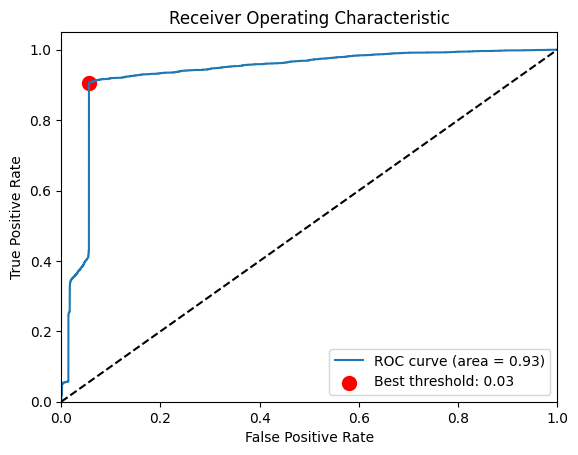

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def get_logits(
    browser,
    qrels_valid,
    queries_embeddings,
    corpus_embeddings,
    encoder,
    ppr_dict,
    beta=0.9,
    temperature=2.0,
    top_k=30,
):
    preds = []
    targets = []

    for query_id in tqdm(qrels_valid.keys()):
        q_embedding = {query_id: queries_embeddings[query_id]}
        c_embedding =  {doc_id: corpus_embeddings[doc_id] for doc_id in qrels_valid[query_id].keys()}
        ppr = ppr_dict[query_id]

        results = browser(q_embedding, c_embedding, encoder, ppr, beta=beta, temperature=temperature, top_k=top_k)
        
        preds.extend(list(dict(sorted(results.items())).values()))
        targets.extend(list(dict(sorted(qrels_valid[query_id].items())).values()))

    y_pred = np.array(preds)
    y_true = np.array(targets)
    return y_true, y_pred

def get_best_threshold(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Youden's J statistic
    J = tpr - fpr
    best_idx = np.argmax(J)

    return thresholds[best_idx], fpr[best_idx], tpr[best_idx]

def plot_auroc(y_true: np.ndarray, y_pred: np.ndarray):

    auc = roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Youden's J statistic
    J = tpr - fpr
    best_idx = np.argmax(J)
    best_threshold = thresholds[best_idx]

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.scatter(fpr[best_idx], tpr[best_idx], s=100, c='red', label=f'Best threshold: {best_threshold:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return best_threshold

y_true, y_pred = get_logits(
    browser, 
    qrels_valid,
    queries_embeddings,
    corpus_embeddings,
    encoder,
    ppr_dict,
    beta=0.99,
    temperature=3.0,
)

best_threshold = plot_auroc(y_true=y_true, y_pred=y_pred)

In [23]:
test_queries = load_test('data/test_final.tsv')
for id in test_queries.keys():
    length = len(test_queries[id])
    print(f"Query ID: {id}, length: {length}")


Query ID: 7b901e88e8a4afcc4c60c52833820156525f4aed, length: 30
Query ID: 8aba3628ad8c9cec11b2b518a96b883bda8b3cbb, length: 30
Query ID: 39d428fd8c6b73ed070921a856f03c2c5b5377ba, length: 30
Query ID: bcdd5670761de0087d2d2bb0388da697b0d4348c, length: 30
Query ID: 9c824df69c7c6fc350d2981bed00b6df6ffb33ad, length: 30
Query ID: fd4537b92ab9fa7c653e9e5b9c4f815914a498c0, length: 30
Query ID: 30c9a7660281ad8e4538ff9beb20282c74fac810, length: 30
Query ID: 66ef0f611b2b5b22dd3eb13a144c0e7d3286623a, length: 30
Query ID: 7a59595f1859b72761b34892be8b6dc43f71d01e, length: 30
Query ID: 46c87eae824a442323147a845e285167f283dd08, length: 30
Query ID: 5aadc803228b70c3cc6b31e332770d47d7fb1e6e, length: 30
Query ID: 8c872ecd87945e71fcd9fa1b6cb1133cfe805bf2, length: 29
Query ID: 9003fb79e7848ced3be975c3d87a9348a4b8d377, length: 29
Query ID: 8384094ce1b342da9eabd2ec939e9bb16ca7ff5c, length: 30
Query ID: 9759c425008506dac507ed26057febd9cab822b8, length: 30
Query ID: 23fa7b866a1b1fee7bb71c8b5a9235cca7120bbc, len

In [24]:
ppr_dict_test = get_all_ppr(G, test_queries, alpha=0.9)

  0%|          | 0/300 [00:00<?, ?it/s]

In [25]:
def predict_browser(
    browser,
    test_set,
    queries_embeddings,
    corpus_embeddings,
    encoder,
    ppr_dict: dict[str, float] = None,
    beta: float = 0.99,
    temperature: float = 3.0,
):  
    preds = {}
    for query_id in tqdm(test_set.keys()):
        q_embedding = {query_id: queries_embeddings[query_id]}
        c_embedding = {doc_id: corpus_embeddings[doc_id] for doc_id in test_set[query_id].keys()}
        ppr = ppr_dict[query_id]

        results = browser(q_embedding, c_embedding, encoder, ppr, beta=beta, temperature=temperature, top_k=30)
        threshold = len(test_set[query_id]) - 25
        results = {k: (1 if i < threshold else 0) for i, k in enumerate(results.keys())}
        preds[query_id] = results
    return preds

In [26]:
def save_predictions(preds: dict[str, dict[str, int]], test_set: dict[str, dict[str, int]], file_path: str):
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write("RowId,query-id,corpus-id,score\n")
        row_id = 1
        for query_id in test_set.keys():
            for doc_id in test_set[query_id].keys():
                score = preds[query_id].get(doc_id, 0)
                f.write(f"{row_id},{query_id},{doc_id},{score}\n")
                row_id += 1

In [27]:
preds = predict_browser(
    browser,
    test_queries,
    queries_embeddings,
    corpus_embeddings,
    encoder,
    ppr_dict_test,
    beta=0.99,
    temperature=3.0,
)

save_predictions(preds, test_queries, 'data/test_predictions.csv')

  0%|          | 0/300 [00:00<?, ?it/s]